
**Download introgression landscape from Skov et al. (Supplementary dataset 1) and liftover to hg19**

In [9]:
!wget https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-020-2225-9/MediaObjects/41586_2020_2225_MOESM3_ESM.txt
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/liftOver/hg38ToHg19.over.chain.gz
!CrossMap.py hg38ToHg19.over.chain.gz <(tail -n+2 41586_2020_2225_MOESM3_ESM.txt | cut -f1-3,13) introgressed_fragments_hg19.txt

--2024-04-12 14:44:27--  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/liftOver/hg38ToHg19.over.chain.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1246411 (1.2M) [application/x-gzip]
Saving to: ‘hg38ToHg19.over.chain.gz’

hg38ToHg19.over.cha 100%[===================>]   1.19M  2.73MB/s    in 0.4s    

2024-04-12 14:44:28 (2.73 MB/s) - ‘hg38ToHg19.over.chain.gz’ saved [1246411/1246411]



#### Tile genome into windows

In [10]:
!wget -O- https://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/hg19.chrom.sizes | sed 's/chr//' | grep -w -P "[1-9][0-9]?" | sort -k1n > hg19.chrom.sizes
!bedtools makewindows -g hg19.chrom.sizes -w 10000 > hg19_10kb_windows.bed

--2024-04-12 14:45:37--  https://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/hg19.chrom.sizes
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1971 (1.9K)
Saving to: ‘STDOUT’

-                   100%[===================>]   1.92K  --.-KB/s    in 0s      

2024-04-12 14:45:37 (2.27 GB/s) - written to stdout [1971/1971]



#### Compute introgression frequency per window

In [11]:
!bedtools intersect -a hg19_10kb_windows.bed -b introgressed_fragments_hg19.txt -wao | awk -F '\t' 'BEGIN{OFS="\t"}{print $1, $2, $3, $7 * $8}' | bedtools groupby -g 1,2,3 -c 4 -o sum | awk -F '\t' 'BEGIN{OFS="\t"}{print $1, $2, $3, $4 / 10000 / 55132}' > introgression_frequencies_10kb.bed

There are 27566 individuals in Skov et al --> 55132 haplotypes

#### Load SNP data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybedtools import BedTool

def read_snps(fname):
    snps_dict = dict()
    with open(fname, 'r') as snps:
        for line in snps:
            line = line.strip().split('\t')
            if len(line) < 2:
                continue
            snps_dict[line[1]] = {'target': (int(line[0].split(':')[0]), int(line[0].split(':')[1]) - 1)}
            snps_dict[line[1]]['controls'] = []
            for control in line[2:]:
                snps_dict[line[1]]['controls'].append((int(control.split(':')[0]), int(control.split(':')[1]) - 1))
    snps.close()
    snps_dict = {values['target']: values['controls'] for values in snps_dict.values()}
    
    return snps_dict

heilmann = read_snps('Heilmann_autosome_matched_control_maf_Eur_hg19.txt')
hagenaar = read_snps('Hagenaars_autosome_matched_control_maf_Eur_hg19.txt')

#### Load introgression_frequencies

In [2]:
freq = pd.read_csv('introgression_frequencies_10kb.bed', names=['chrom', 'start', 'end', 'freq'], sep='\t')

**Intersect with introgression map**

In [3]:
def get_intersect_snps_introgression_map(snps, introgression_map, n_controls=None, drop_same_window=False):
    snps = pd.DataFrame(snps, columns=['chrom', 'start'])
    snps['end'] = snps.start.values
    snps.start -= 1
    cols = ['snp_chrom', 'snp_start', 'snp_end']
    cols.extend(introgression_map.columns.values.tolist())
    cols.append('overlap')
    intersect = BedTool.from_dataframe(snps).intersect(
        BedTool.from_dataframe(introgression_map), wao=True).to_dataframe(names=cols)
    if drop_same_window:
        intersect.drop_duplicates(['chrom', 'start', 'end'], inplace=True)
    try:
        introgression_freq = intersect.freq.values
        if not n_controls is None:
            introgression_freq = np.random.choice(introgression_freq, n_controls)
    except AttributeError:
        introgression_freq = np.array([])
    introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
        
    return introgression_freq    

In [4]:
target_snps  = heilmann.keys()
control_snps = heilmann.values()
heilmann_introgression_freq = get_intersect_snps_introgression_map(target_snps, freq)
heilmann_controls_introgression_freq = []
for controls in control_snps:
    heilmann_controls_introgression_freq.append(get_intersect_snps_introgression_map(controls, freq, n_controls=1000))
ind_to_keep = [i for i, c in enumerate(heilmann_controls_introgression_freq) if c.shape[0] == 1000]
heilmann_introgression_freq = heilmann_introgression_freq[ind_to_keep]
heilmann_controls_introgression_freq =  np.stack([c for c in heilmann_controls_introgression_freq if c.shape[0] == 1000])

/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  in

/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  in

In [5]:
target_snps  = hagenaar.keys()
control_snps = hagenaar.values()
hagenaar_introgression_freq = get_intersect_snps_introgression_map(target_snps, freq)
hagenaar_controls_introgression_freq = []
for controls in control_snps:
    hagenaar_controls_introgression_freq.append(get_intersect_snps_introgression_map(controls, freq, n_controls=1000))
           
hagenaar_controls_introgression_freq =  np.stack(hagenaar_controls_introgression_freq)

/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  in

/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  in

/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  in

/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  in

/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  in

/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)
/scratch/5954385/ipykernel_210677/485770835.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  in

**Visualize**

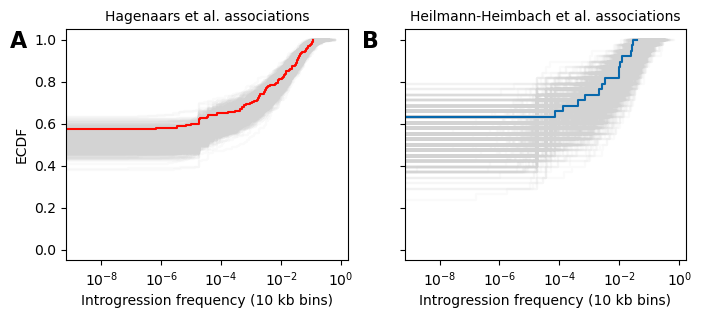

In [6]:
def plot_neanderthal_enrichment(targets, controls, target_color, ax, alpha=1, plot_controls=True):
    if plot_controls:
        for i in range(controls.shape[1]):
            control_x = np.concatenate([[controls[:, i].min()], np.sort(controls[:, i])])
            control_y = np.arange(0, len(controls[:, i]) +1) / float(controls[:, i].shape[0])
            ax.step(control_x,
                    control_y,
                    color='lightgray', alpha=0.1)
    target_x = np.concatenate([[targets.min()], np.sort(targets)])
    target_y = np.arange(0, len(targets) +1) / float(targets.shape[0])
    ax.step(target_x,
            target_y,
            color=target_color, alpha=alpha)
    return ax


fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 3))
ax[0] = plot_neanderthal_enrichment(hagenaar_introgression_freq, hagenaar_controls_introgression_freq, '#FF0800', ax[0])
ax[1] = plot_neanderthal_enrichment(heilmann_introgression_freq, heilmann_controls_introgression_freq, '#0868AC', ax[1])

# ax[0].set_ylim([0, 1.05])
ax[0].set_xscale('log')
ax[1].set_xscale('log')

# ax[0].set_xlim([min_freq - min_freq /10 , max_freq + 0.1])
ax[0].set_xlabel('Introgression frequency (10 kb bins)')
ax[1].set_xlabel('Introgression frequency (10 kb bins)')

ax[0].set_ylabel('ECDF')
ax[0].annotate("A", (1, 1), (-0.2, 0.92), xycoords='axes fraction', fontsize=16, fontweight='bold')
ax[0].set_title('Hagenaars et al. associations', fontsize=10)
ax[1].set_title('Heilmann-Heimbach et al. associations', fontsize=10)

ax[1].annotate("B", (1, 1), (-0.15, 0.92), xycoords='axes fraction', fontsize=16, fontweight='bold')
fig.savefig('neanderthal_enrichment_mpb_variants.png', bbox_inches='tight', dpi=600)
fig.savefig('neanderthal_enrichment_mpb_variants.pdf', bbox_inches='tight', dpi=600)

**Perform empirical power analysis to detect Neanderthal enrichment among MPB associations** 

**Download true archaic SNPs from Skov et al. (Supplementary dataset 2)**

In [ ]:
! wget -O https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-020-2225-9/MediaObjects/41586_2020_2225_MOESM4_ESM.txt

**Lift over to hg19 and get introgression frequencies for archaic SNPs**

In [7]:
from liftover import get_lifter
from collections import defaultdict
from scipy.stats import kstest, hmean
from matplotlib.lines import Line2D
import matplotlib.ticker as tck


def get_pvalues(target, controls):
    pvalues = []
    for n in range(controls.shape[1]):
        pvalues.append(kstest(target, controls[:, n], alternative='less').pvalue)
    return hmean(pvalues)

# positions are in hg38
archaic_snps = pd.read_csv('41586_2020_2225_MOESM4_ESM.txt', sep='\t', header=0)
archaic_snps = archaic_snps[archaic_snps.chrom != 'chrX']
archaic_snps = archaic_snps.loc[:, ('chrom', "pos")].values.tolist()
# liftover to hg19
converter = get_lifter('hg38', 'hg19') 
archaic_snps_hg19 = []
for snp in archaic_snps:
    pos = converter[snp[0]][snp[1]]
    if len(pos) != 1:
        continue
    archaic_snps_hg19.append([int(pos[0][0].replace('chr', '')), pos[0][1]])
# calculate introgression frequencies of lifted over coordinates
archaic_snps_freq = get_intersect_snps_introgression_map(archaic_snps_hg19, freq, drop_same_window=True)

/scratch/5838273/ipykernel_244614/20790323.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  introgression_freq = np.where(introgression_freq == '.', 0, introgression_freq).astype(float)


**Estimate power by replacing fractions of MPB associations with true archaic SNPs**

In [40]:
snps_to_substitute_heilmann = np.arange(0, heilmann_introgression_freq.shape[0], 
                                        heilmann_introgression_freq.shape[0] // 10)
if snps_to_substitute_heilmann[-1] < heilmann_introgression_freq.shape[0]:
    snps_to_substitute_heilmann = np.concatenate([snps_to_substitute_heilmann, 
                                                  [heilmann_introgression_freq.shape[0]]])
snps_to_substitute_heilmann = np.sort(np.unique(np.concatenate([snps_to_substitute_heilmann[1:], 
                                                                np.array([17, 18, 19, 20])])))
pvals_heilmann = defaultdict(list)
power_heilmann = []
for i, n_snps in enumerate(snps_to_substitute_heilmann):
    if n_snps == 0:
        pvals_heilmann['target'] = get_pvalues(heilmann_introgression_freq, 
                                               heilmann_controls_introgression_freq)
    else:
        c_targets = np.hstack([np.random.choice(heilmann_introgression_freq, 
                                                (1000, heilmann_introgression_freq.shape[0] - n_snps)),
                               np.random.choice(archaic_snps_freq, (1000, n_snps))])
        for n in range(c_targets.shape[0]):
            pvals_heilmann[n_snps].append(get_pvalues(c_targets[n, :], 
                                                      heilmann_controls_introgression_freq))
        power = np.where(np.array(pvals_heilmann[n_snps]) < 0.05)[0].shape[0] / len(pvals_heilmann[n_snps])
        power_heilmann.append(power)


In [42]:
snps_to_substitute_hagenaar = np.arange(0, hagenaar_introgression_freq.shape[0], 
                                        hagenaar_introgression_freq.shape[0] // 10)
if snps_to_substitute_hagenaar[-1] < hagenaar_introgression_freq.shape[0]:
    snps_to_substitute_hagenaar = np.concatenate([snps_to_substitute_hagenaar, 
                                                  [hagenaar_introgression_freq.shape[0]]])
snps_to_substitute_hagenaar = np.sort(np.unique(np.concatenate([snps_to_substitute_hagenaar[1:], 
                                                                np.array([48, 49, 50, 51])])))
pvals_hagenaar = defaultdict(list)
power_hagenaars = []

for i, n_snps in enumerate(snps_to_substitute_hagenaar):
    if n_snps == 0:
        pvals_hagenaar['target'] = get_pvalues(hagenaar_introgression_freq, 
                                               hagenaar_controls_introgression_freq)
        
    else:
        c_targets = np.hstack([np.random.choice(hagenaar_introgression_freq, 
                                                (1000, hagenaar_introgression_freq.shape[0] - n_snps)),
                               np.random.choice(archaic_snps_freq, (1000, n_snps))])
        for n in range(c_targets.shape[0]):
            pvals_hagenaar[n_snps].append(get_pvalues(c_targets[n, :], 
                                                      hagenaar_controls_introgression_freq))
        power = np.where(np.array(pvals_hagenaar[n_snps]) < 0.05)[0].shape[0] / len(pvals_hagenaar[n_snps])
        power_hagenaars.append(power)

            

**Visualize**

Text(-0.2, 0.92, 'B')

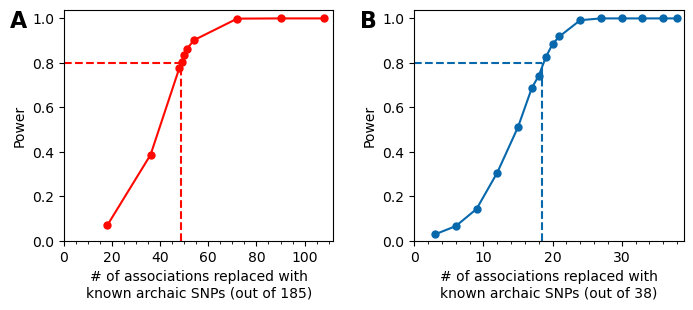

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=.3)
ax[0].plot(snps_to_substitute_hagenaar[snps_to_substitute_hagenaar < 112], 
           np.array(power_hagenaars)[snps_to_substitute_hagenaar < 112], marker='o', color='#FF0800',
           markersize=5)
threshold = snps_to_substitute_hagenaar[np.where(np.array(power_hagenaars) >= 0.8)[0]][0]
ax[0].set_xlabel('# of associations replaced with\nknown archaic SNPs (out of 185)')
ax[0].set_xlim([0, 112])
ax[0].axhline(0.8, ls='--', color='#FF0800', xmin=0, xmax=(threshold -0.5) / 112)
ax[0].set_ylim([0, 1.04])
ax[0].axvline(threshold - 0.5, ls='--', color='#FF0800', ymin=0, ymax=0.8 / 1.04)
ax[0].xaxis.set_minor_locator(tck.AutoMinorLocator())

ax[1].plot(snps_to_substitute_heilmann, power_heilmann, marker='o', color='#0868AC', markersize=5)
threshold = snps_to_substitute_heilmann[np.where(np.array(power_heilmann) >= 0.8)[0]][0]
ax[1].set_xlabel('# of associations replaced with\nknown archaic SNPs (out of 38)')
ax[1].set_xlim([0, 39])
ax[1].axhline(0.8, ls='--', color='#0868AC', xmin=0, xmax=(threshold -0.5) / 39)
ax[1].set_ylim([0, 1.04])
ax[1].axvline(threshold - 0.5, ls='--', color='#0868AC', ymin=0, ymax=0.8 / 1.04)
ax[1].xaxis.set_minor_locator(tck.AutoMinorLocator())
ax[0].set_ylabel("Power")
ax[1].set_ylabel("Power")
ax[0].annotate("A", (1, 1), (-0.2, 0.92), xycoords='axes fraction', fontsize=16, fontweight='bold')
ax[1].annotate("B", (1, 1), (-0.2, 0.92), xycoords='axes fraction', fontsize=16, fontweight='bold')